# Solving the mild-slope equation in a two spherical shoal using PINN
## Bibliography
### Numerical solutions of mild slope equation by generalized ﬁnite diﬀerence method. Authors: Ting Zhang, Ying-Jie Huang, Lin Liang, Chia-Ming Fan, Po-Wei Li
### A Modified Mild‐Slope Model for the Hydrodynamic Analysis of Arrays of Heaving WECs in Variable Bathymetry Regions. Authors: Markos Bonovas, Alexandros Magkouris and Kostas Belibassakis 

# Libraries

In [3]:
import jax, optax
import pickle
import functools
import matplotlib.pyplot, matplotlib.animation
import numpy

# Set and verify device
jax.config.update('jax_platform_name', 'gpu')
jax.config.update("jax_enable_x64", True)
print(jax.lib.xla_bridge.get_backend().platform)

gpu


# Parameters

In [4]:
# Neural network parameters
parameters = {}
parameters['seed'] = 351
parameters['n_features'] = 2        # Input dimension (x1, x2)
parameters['n_targets'] = 2         # Output dimension. It's a complex number (y1 + j*y2)
parameters['hidden_layers'] = [50, 50, 50, 50, 50]   # Hidden layers structure
parameters['layers'] = [parameters['n_features']] + parameters['hidden_layers'] + [parameters['n_targets']]

# Training parameters
parameters['learning_rate'] = optax.linear_schedule(0.005, 0.00001, transition_steps = 50, transition_begin = 5000)
parameters['optimizer'] = optax.adam(parameters['learning_rate'])
parameters['maximum_num_epochs'] = 50000
parameters['report_steps'] = 1000
parameters['options'] = 1           # 1: we start a new training. 2: We continue the last training. 
                                    # Other cases: We just load the last training

# Data parameters
parameters['radius'] = 1
parameters['n_inside'] = 2500        # number of points inside the domain
parameters['n_bound'] = 200          # number of points at the boundary
parameters['domain_bounds'] =  jax.numpy.column_stack(([-jax.numpy.pi, -jax.numpy.pi, 0], [jax.numpy.pi, jax.numpy.pi, -jax.numpy.pi]))        # minimal and maximal value of each axis (x,y,z)



# Neural network

In [5]:
class MLP:
    """
        Create a multilayer perceptron and initialize the neural network
    Inputs :
        A SEED number and the layers structure
    """
    def __init__(self, key, layers):
        self.key = key
        self.keys = jax.random.split(self.key,len(layers))
        self.layers = layers
        self.params = []

    def MLP_create(self):
        """
        Initialize the MLP weigths and bias
        Parameters
        ----------
        Returns
        -------
        params : list of parameters[[w1,b1],...,[wn,bn]]
            -- weights and bias
        """
        for layer in range(0, len(self.layers)-1):
            in_size,out_size = self.layers[layer], self.layers[layer+1]
            weights = jax.nn.initializers.glorot_normal()(self.keys[layer], (out_size, in_size), jax.numpy.float32)
            bias = jax.nn.initializers.lecun_normal()(self.keys[layer], (out_size, 1), jax.numpy.float32).reshape((out_size, ))
            self.params.append((weights, bias))
        return self.params
        

    @functools.partial(jax.jit, static_argnums=(0,))    
    def NN_evaluation(self, params, inputs):
        """
        Evaluate a position XY using the neural network    
        Parameters
        ----------
        params : list of parameters[[w1,b1],...,[wn,bn]]
            -- weights and bias
        inputs : jax.numpy.ndarray[[batch_size,batch_size]]
            -- points in the mesh
        Returns
        -------
        output : jax.numpy.array[batch_size]
            -- neural network output 
        """
        for layer in range(0, len(params)-1):
            weights, bias = params[layer]
            inputs = jax.nn.tanh(jax.numpy.add(jax.numpy.dot(inputs, weights.T), bias))
        weights, bias = params[-1]
        real_and_imaginary_layers = jax.numpy.dot(inputs, weights.T)+bias # The first output of the NN is the real part, the second is the imaginary part
        output = jax.lax.complex(real_and_imaginary_layers[0], real_and_imaginary_layers[1])   

        return output


# Operators

In [6]:
class PDE_operators:
    """
        Class with the operators used to solve the PDE
    Input:
        A function that we want to compute the respective operator
    """
    def __init__(self, psi_function, c_function, cg_function):
        self.psi_function = psi_function
        self.c_function = c_function
        self.cg_function = cg_function


    @functools.partial(jax.jit, static_argnums=(0,))    
    def comp_grad_psi(self, params, inputs):
        """
        Compute the gradient of the psi function
        Parameters
        ----------
        params : list of parameters[[w1,b1],...,[wn,bn]]
            -- weights and bias
        inputs : jax.numpy.ndarray[[batch_size,batch_size]]
            -- coordinates and time  (x,y)
        Returns
        -------
        gradient : jax.numpy.ndarray[[batch_size,batch_size]]
            -- numerical values of the gradient applied to the inputs
        """

        fun = lambda params, x, y: self.psi_function(params, x, y)

        @functools.partial(jax.jit)    
        def action(params, x, y):               # function to vectorize the laplacian
            u_x = jax.jacfwd(fun, 1)(params, x, y)
            u_y = jax.jacfwd(fun, 2)(params, x, y)
            return jax.numpy.column_stack((u_x, u_y))

        vec_fun = jax.vmap(action, in_axes = (None, 0, 0))
        gradient = vec_fun(params, inputs[:,0], inputs[:,1])
        gradient = gradient.reshape((gradient.shape[0], gradient.shape[2]))

        return gradient

    @functools.partial(jax.jit, static_argnums=(0,))    
    def comp_grad_c_cg_gradpsi(self, params, inputs):
        """
        Compute the dot product nabla.(c*cg*gradpsi)
        Parameters
        ----------
        params : list of parameters[[w1,b1],...,[wn,bn]]
            -- weights and bias
        inputs : jax.numpy.ndarray[[batch_size,batch_size,batch_size]]
            -- coordinates and time  (x,y)
        Returns
        -------
        res : jax.numpy.ndarray[[batch_size,batch_size]]
            -- numerical values of the dot_product nabla.(c*cg*gradpsi) applied to the inputs
        """

        funx = lambda params, x, y: self.c_function(x,y)*self.cg_function(x,y)*self.comp_grad_psi(params, jax.numpy.column_stack((x, y)))[:,0]
        funy = lambda params, x, y: self.c_function(x,y)*self.cg_function(x,y)*self.comp_grad_psi(params, jax.numpy.column_stack((x, y)))[:,1]

        @functools.partial(jax.jit)    
        def action(params, x, y):               # function to vectorize the laplacian
            u_x = jax.jacfwd(funx, 1)(params, x, y)
            u_y = jax.jacfwd(funy, 2)(params, x, y)
            return u_x + u_y

        vec_fun = jax.vmap(action, in_axes = (None, 0, 0))
        res = vec_fun(params, inputs[:,0], inputs[:,1])

        return res.reshape(-1)


    @functools.partial(jax.jit, static_argnums=(0,))    
    def dsol_dt(self, params, inputs):
        """
        Compute the time derivative os the solution
        Parameters
        ----------
        params : list of parameters[[w1,b1],...,[wn,bn]]
            -- weights and bias
        inputs : jax.numpy.ndarray[[batch_size,batch_size,batch_size,batch_size]]
            -- coordinates and time  (x,y,z,t)
        Returns
        -------
        res : jax.numpy.ndarray[batch_size]
            -- numerical values of the time derivative applied to the inputs
        """

        fun = lambda params, x, y, z, t: self.psi_function(params, x, y, z, t)

        @functools.partial(jax.jit)    
        def action(params, x, y, z, t):               # function to vectorize the laplacian
            u_t = jax.jacfwd(fun, 4)(params, x, y, z, t)
            return u_t

        vec_fun = jax.vmap(action, in_axes = (None, 0, 0, 0, 0))
        res = vec_fun(params, inputs[:,0], inputs[:,1], inputs[:,2], inputs[:,3])

        return res.reshape(-1)


# Physics domain

In [7]:
class PHYSICS():
    """
        Class with the physical approach and parameters
    Input:
        Wave vector, spatial 2d solution of the mild-slope equation and shoal coordinates
    """
    
    # Class initialization
    def __init__(self, wave_vector, spatial_2dsolution, shoal_coordinates):
        self.spatial_2dsolution = spatial_2dsolution
        self.wave_vector = wave_vector
        self.shoal_coordinates = shoal_coordinates

        self.operators = PDE_operators(self.solution, self.c_coeff, self.cg_coeff)
        self.dsol_dt = self.operators.dsol_dt

    @functools.partial(jax.jit, static_argnums=(0,))    
    def omega_coeff(self, x, y):
        """
        Compute the frequency omega at in the couple (x,y)
        Parameters
        ----------
        x : jax.numpy.ndarray[batch_size]
            -- points in the axis x
        y : jax.numpy.ndarray[batch_size]
            -- points in the axis y
        Returns
        -------
        omega : jax.numpy.ndarray[batch_size]
            -- omega in each couple (x,y)
        """
        omega = jax.numpy.sqrt(9.81*self.k_coeff(x,y)*jax.numpy.tanh(self.k_coeff(x,y)*self.height_function(x,y)))
        
        return omega


    @functools.partial(jax.jit, static_argnums=(0,))    
    def k_coeff(self, x, y):
        """
        Compute the coefficient k in the couple (x,y)
        Parameters
        ----------
        x : jax.numpy.ndarray[batch_size]
            -- points in the axis x
        y : jax.numpy.ndarray[batch_size]
            -- points in the axis y
        Returns
        -------
        k : jax.numpy.ndarray[batch_size]
            -- Coefficient k in each couple (x,y)
        """

        return self.wave_vector


    @functools.partial(jax.jit, static_argnums=(0,))    
    def c_coeff(self, x, y):
        """
        Compute the coefficient c in the couple (x,y)
        Parameters
        ----------
        x : jax.numpy.ndarray[batch_size]
            -- points in the axis x
        y : jax.numpy.ndarray[batch_size]
            -- points in the axis y
        Returns
        -------
        c : jax.numpy.ndarray[batch_size]
            -- Coefficient c in each couple (x,y)
        """
        c = self.omega_coeff(x,y)/self.k_coeff(x,y)

        return c


    @functools.partial(jax.jit, static_argnums=(0,))    
    def cg_coeff(self, x, y):
        """
        Compute the coefficient cg in the couple (x,y)
        Parameters
        ----------
        x : jax.numpy.ndarray[batch_size]
            -- points in the axis x
        y : jax.numpy.ndarray[batch_size]
            -- points in the axis y
        Returns
        -------
        cg : jax.numpy.ndarray[batch_size]
            -- Coefficient cg in each couple (x,y)
        """
        nprime = 0.5*(1 + 2*self.k_coeff(x,y)*self.height_function(x,y)/jax.numpy.sinh(2*self.k_coeff(x,y)*self.height_function(x,y)))
        cg = nprime*self.omega_coeff(x,y)/self.k_coeff(x,y)

        return cg


    @functools.partial(jax.jit, static_argnums=(0,))    
    def height_function(self, x, y):
        """
        Compute the height in the couple (x,y)
        Parameters
        ----------
        x : jax.numpy.ndarray[batch_size]
            -- points in the axis x
        y : jax.numpy.ndarray[batch_size]
            -- points in the axis y
        Returns
        -------
        h : jax.numpy.ndarray[batch_size]
            -- Height each couple (x,y)
        """
        fun = lambda tx, ty: self.shoal_coordinates[:,2][jax.numpy.argmin(jax.numpy.sqrt(((tx-self.shoal_coordinates[:,0])**2+(ty-self.shoal_coordinates[:,1])**2)))]
        vec_fun = jax.vmap(jax.jit(fun), in_axes = (0, 0))
        h = -vec_fun(x.reshape(-1), y.reshape(-1))

        return h


    @functools.partial(jax.jit, static_argnums=(0,))    
    def f_dependence(self, inputX, inputY, inputZ):
        """
        Compute the function fz in the point (x,y,z)
        Parameters
        ----------
        x : jax.numpy.ndarray[batch_size]
            -- points in the axis x
        y : jax.numpy.ndarray[batch_size]
            -- points in the axis y
        z : jax.numpy.ndarray[batch_size]
            -- points in the axis z
        Returns
        -------
        fz : jax.numpy.ndarray[batch_size]
            -- fz in each point (x,y,z)
        """
        fz = (jax.numpy.cosh(self.k_coeff(inputX, inputY)*(self.height_function(inputX, inputY)+ inputZ))/jax.numpy.cosh(self.k_coeff(inputX, inputY)*self.height_function(inputX, inputY))).reshape(-1)

        return fz


    @functools.partial(jax.jit, static_argnums=(0,))    
    def solution(self, params, x,y,z,t):
        """
        Compute the solution in the point (x,y,z,t)
        Parameters
        ----------
        x : jax.numpy.ndarray[batch_size]
            -- points in the axis x
        y : jax.numpy.ndarray[batch_size]
            -- points in the axis y
        z : jax.numpy.ndarray[batch_size]
            -- points in the axis z
        t : jax.numpy.ndarray[batch_size]
            -- points in the time
        Returns
        -------
        res : jax.numpy.ndarray[batch_size]
            -- result in each point (x,y,z,t)
        """
        H = 2*self.omega_coeff(x,y)*abs(self.spatial_2dsolution(params,x,y))/9.81
        res = jax.numpy.imag(9.81*H/(2*self.omega_coeff(x,y))*self.spatial_2dsolution(params, x,y)*self.f_dependence(x,y,z)*jax.numpy.exp(jax.lax.complex(0.0,jax.numpy.real(-self.omega_coeff(x,y)*t))))

        return res


    @functools.partial(jax.jit, static_argnums=(0,))    
    def elevation(self, params, x,y,t):
        """
        Compute the surface displacement in the point (x,y,t)
        Parameters
        ----------
        x : jax.numpy.ndarray[batch_size]
            -- points in the axis x
        y : jax.numpy.ndarray[batch_size]
            -- points in the axis y
        t : jax.numpy.ndarray[batch_size]
            -- points in the time
        Returns
        -------
        res : jax.numpy.ndarray[batch_size]
            -- Displacement in each point (x,y,z,t)
        """
        inputs = jax.numpy.column_stack((x,y,jax.numpy.zeros_like(y),t))
        res = -self.dsol_dt(params, inputs)/9.81

        return res


    @functools.partial(jax.jit, static_argnums=(0,))    
    def incident_psi(self, params, inputs, a=0.01):
        """
        Compute the incident wave in inputs points
        Parameters
        ----------
        params : list of parameters[[w1,b1],...,[wn,bn]]
            -- weights and bias
        inputs : jax.numpy.ndarray[[batch_size, batch_size]]
            -- (x,y) points in the mesh
        Returns
        -------
        incident_wave : a float.64
            -- incident_wave applied to inputs
        """
        incident_wave = (2*a*9.81/self.c_coeff(inputs[:,0], inputs[:,1])*jax.numpy.exp(-self.k_coeff(inputs[:,0],inputs[:,1])*inputs[:,1])).reshape(-1)
        
        return incident_wave


# Physics Informed Neural Network

In [8]:
class PINN:
    """
    Solve a PDE using Physics Informed Neural Networks   
    Input:
        The evaluation function of the neural network
    """
    def __init__(self, NN_evaluation, optimizer, XYZ_shoal):
        self.NN_evaluation = NN_evaluation
        self.optimizer = optimizer

        physics_parameters = PHYSICS(wave_vector = 0.5, spatial_2dsolution = self.spatial_2dsolution, shoal_coordinates = XYZ_shoal)
        self.k_coeff = physics_parameters.k_coeff
        self.c_coeff = physics_parameters.c_coeff
        self.cg_coeff = physics_parameters.cg_coeff
        self.incident_psi = physics_parameters.incident_psi
        self.elevation = physics_parameters.elevation

        self.operators = PDE_operators(self.spatial_2dsolution, self.c_coeff, self.cg_coeff)
        self.gradient_psi = self.operators.comp_grad_psi
        self.dsol_dt = self.operators.dsol_dt
        self.gradient_c_cg_gradpsi = self.operators.comp_grad_c_cg_gradpsi


    @functools.partial(jax.jit, static_argnums=(0,))    
    def spatial_2dsolution(self, params, inputX, inputY):
        """
        Compute the solution of the PDE on the points (x,y)
        Parameters
        ----------
        params : list of parameters[[w1,b1],...,[wn,bn]]
            -- weights and bias
        inputX : jax.numpy.array[batch_size]
            -- points on the x-axis of the mesh
        inputY : jax.numpy.array[batch_size]
            -- points on the y-axis of the mesh
        Returns
        -------
        applied_solution : jax.numpy.ndarray[batch_size]
            -- PINN solution applied to inputs. return u, a complex number
        """
        inputs = jax.numpy.column_stack((inputX, inputY))
        NN_output = jax.vmap(functools.partial(jax.jit(self.NN_evaluation), params))(inputs)
        
        return NN_output


    @functools.partial(jax.jit, static_argnums=(0,))    
    def loss_residual_pde(self, params, inputs):
        """
        Compute the residual of the pde inside the domain
        Parameters
        ----------
        params : list of parameters[[w1,b1],...,[wn,bn]]
            -- weights and bias
        inside : jax.numpy.ndarray[[batch_size, batch_size]]
            -- (x,y) points from the mesh
        Returns
        -------
        loss_residual : a float.64
            -- loss function applied to inputs
        """

        preds_loss = self.gradient_c_cg_gradpsi(params, inputs) + self.k_coeff(inputs[:,0],inputs[:,1])**2*self.c_coeff(inputs[:,0], inputs[:,1])*self.cg_coeff(inputs[:,0], inputs[:,1])*self.spatial_2dsolution(params, inputs[:,0], inputs[:,1])
        loss_value = jax.numpy.linalg.norm(preds_loss)**2/preds_loss.shape[0]
        return loss_value

    
    @functools.partial(jax.jit, static_argnums=(0,))    
    def loss_reflective_left_boundary(self, params, inputs):
        """
        Compute the loss function at the left boundary
        Parameters
        ----------
        params : list of parameters[[w1,b1],...,[wn,bn]]
            -- weights and bias
        bound : jax.numpy.ndarray[[batch_size, batch_size]]
            -- (x,y,t) points from boundary
        Returns
        -------
        loss_left : a float.64
            -- loss function applied to inputs
        """
        normal_left = jax.numpy.column_stack((-jax.numpy.ones(inputs.shape[0]), jax.numpy.zeros(inputs.shape[0])))
        preds_left = jax.numpy.einsum('ij,ij->i',self.gradient_psi(params, inputs), normal_left)
        loss_left = jax.numpy.linalg.norm(preds_left)**2/preds_left.shape[0]
        
        return loss_left


    @functools.partial(jax.jit, static_argnums=(0,))    
    def loss_reflective_right_boundary(self, params, inputs):
        """
        Compute the loss function at the right boundary
        Parameters
        ----------
        params : list of parameters[[w1,b1],...,[wn,bn]]
            -- weights and bias
        bound : jax.numpy.ndarray[[batch_size, batch_size]]
            -- (x,y,t) points from boundary
        Returns
        -------
        loss_right : a float.64
            -- loss function applied to inputs
        """
        normal_right = jax.numpy.column_stack((jax.numpy.ones(inputs.shape[0]), jax.numpy.zeros(inputs.shape[0])))
        preds_right = jax.numpy.einsum('ij,ij->i',self.gradient_psi(params, inputs), normal_right)
        loss_right = jax.numpy.linalg.norm(preds_right)**2/preds_right.shape[0]
        
        return loss_right


    @functools.partial(jax.jit, static_argnums=(0,))    
    def loss_absorbing_boundary(self, params, inputs):
        """
        Compute the loss function at the behind boundary
        Parameters
        ----------
        params : list of parameters[[w1,b1],...,[wn,bn]]
            -- weights and bias
        bound : jax.numpy.ndarray[[batch_size, batch_size]]
            -- (x,y,t) points from boundary
        Returns
        -------
        loss_behind : a float.64
            -- loss function applied to inputs
        """
        normal_behind = jax.numpy.column_stack((jax.numpy.zeros(inputs.shape[0]),jax.numpy.ones(inputs.shape[0])))
        preds_behind = jax.numpy.einsum('ij,ij->i',self.gradient_psi(params, inputs), normal_behind) - jax.lax.complex(-jax.numpy.imag(self.k_coeff(inputs[:,0], inputs[:,1])*self.spatial_2dsolution(params, inputs[:,0], inputs[:,1])), jax.numpy.real(self.k_coeff(inputs[:,0], inputs[:,1])*self.spatial_2dsolution(params, inputs[:,0], inputs[:,1])))
        loss_behind = jax.numpy.linalg.norm(preds_behind)**2/preds_behind.shape[0]
      
        return loss_behind


    @functools.partial(jax.jit, static_argnums=(0,))    
    def loss_incident_boundary(self, params, inputs):
        """
        Compute the loss function at the front boundary
        Parameters
        ----------
        params : list of parameters[[w1,b1],...,[wn,bn]]
            -- weights and bias
        bound : jax.numpy.ndarray[[batch_size, batch_size]]
            -- (x,y,t) points from boundary
        Returns
        -------
        loss_front : a float.64
            -- loss function applied to inputs
        """
        normal_front = jax.numpy.column_stack((jax.numpy.zeros(inputs.shape[0]),jax.numpy.ones(inputs.shape[0])))
        preds_front = jax.numpy.einsum('ij,ij->i', self.gradient_psi(params, inputs), normal_front) - jax.lax.complex(-jax.numpy.imag(self.k_coeff(inputs[:,0], inputs[:,1])*(2*self.incident_psi(params, inputs)-self.spatial_2dsolution(params, inputs[:,0], inputs[:,1]))), jax.numpy.real(self.k_coeff(inputs[:,0], inputs[:,1])*(2*self.incident_psi(params, inputs)-self.spatial_2dsolution(params, inputs[:,0], inputs[:,1]))))
        loss_front = jax.numpy.linalg.norm(preds_front)**2/preds_front.shape[0]
      
        return loss_front


    @functools.partial(jax.jit, static_argnums=(0,))    
    def loss_function(self, params, inside, up_points, down_points, left_points, right_points):
        """
        Compute the sum of each loss function
        Parameters
        ----------
        params : list of parameters[[w1,b1],...,[wn,bn]]
            -- weights and bias
        inside : jax.numpy.ndarray[[batch_size, batch_size,batch_size]]
            -- (x,y,t) points from the mesh
        bound : jax.numpy.ndarray[[batch_size, batch_size,batch_size]]
            -- (x,y,t) points from boundary
        initial : jax.numpy.ndarray[[batch_size, batch_size, batch_size]]
            -- (x,y,t) points from initial condition
        Returns
        -------
        loss_sum : a float.64
            -- loss function applied to inputs
        losses : numpy.array(loss_residual, loss_bound, loss_front_behind)
            -- current values of each loss function
        """

        loss1 = self.loss_incident_boundary(params, down_points) 
        loss2 = self.loss_absorbing_boundary(params, up_points)
        loss3 = self.loss_reflective_left_boundary(params, left_points)
        loss4 = self.loss_reflective_right_boundary(params, right_points)

        loss_bound = loss3 + loss4
        loss_residual = self.loss_residual_pde(params, inside)
        loss_front_behind = loss1 + loss2
        loss_sum = loss_bound + loss_residual + loss_front_behind
        losses = jax.numpy.array([loss_residual, loss_bound, loss_front_behind])

        return loss_sum, losses


    @functools.partial(jax.jit, static_argnums=(0,))    
    def train_step(self, params, opt_state, inside, up_points, down_points, left_points, right_points):
        """
        Do just one train step
        Parameters
        ----------
        params : list of parameters[[w1,b1],...,[wn,bn]]
            -- weights and bias
        opt_state : a tuple given by optax
            -- state(hystorical) of the gradient descent
        inside : jax.numpy.ndarray[[batch_size, batch_size,batch_size]]
            -- (x,y,t) points from the mesh
        bound : jax.numpy.ndarray[[batch_size, batch_size,batch_size]]
            -- (x,y,t) points from boundary
        initial : jax.numpy.ndarray[[batch_size, batch_size, batch_size]]
            -- (x,y,t) points from initial condition
        Returns
        -------
        loss : a float.64
            -- loss function applied to inputs
        new_params : list of parameters[[w1,b1],...,[wn,bn]]
            -- weights and bias updated
        opt_state : a tuple given by optax
            -- update the state(hystorical) of the gradient descent
        losses : dictionary with the keys (loss_m, loss_b, loss_i)
            -- current values of each loss function
        """

        (loss,losses), gradient = jax.value_and_grad(self.loss_function, has_aux=True)(params, inside, up_points, down_points, left_points, right_points)
        updates, new_opt_state = self.optimizer.update(gradient, opt_state)
        new_params = optax.apply_updates(params, updates)

        return loss, new_params, new_opt_state, losses

# Generating 3D dataset

### Shoal

In [9]:
X = jax.numpy.linspace(parameters['domain_bounds'][0,0],parameters['domain_bounds'][0,1], 50)
Y = jax.numpy.linspace(parameters['domain_bounds'][1,0],parameters['domain_bounds'][1,1], 50)
Z = jax.numpy.linspace(parameters['domain_bounds'][2,0],parameters['domain_bounds'][2,0],1)
X, Y, Z = jax.numpy.meshgrid(X, Y, Z)
X, Y, Z = X.flatten(), Y.flatten(), Z.flatten()
shoal = jax.numpy.column_stack((X,Y,Z))
shoal = shoal[(shoal[:,0] - 3*parameters['radius']/2)**2+shoal[:,1]**2+shoal[:,2]**2>parameters['radius']**2]
shoal = shoal[(shoal[:,0] + 3*parameters['radius']/2)**2+shoal[:,1]**2+shoal[:,2]**2>parameters['radius']**2]

### Spherical shoal

In [10]:
ran_key, batch_key = jax.random.split(jax.random.PRNGKey(0))
low = jax.numpy.array([-parameters['radius'],-parameters['radius'],-parameters['radius']])
high = jax.numpy.array([parameters['radius'], parameters['radius'], parameters['radius']])
shoal_sphere = numpy.random.uniform(size=(10000000, 3), low=low, high=high)
shoal_sphere = shoal_sphere[shoal_sphere[:,0]**2 + shoal_sphere[:,1]**2 + shoal_sphere[:,2]**2 < parameters['radius']**2 + 0.001]
shoal_sphere = shoal_sphere[shoal_sphere[:,0]**2 + shoal_sphere[:,1]**2 + shoal_sphere[:,2]**2 > parameters['radius']**2 - 0.001]

### Translation

In [11]:
sphere1 = numpy.copy(shoal_sphere)
sphere2 = numpy.copy(shoal_sphere)
sphere1[:,0] = sphere1[:,0] + 3*parameters['radius']/2
sphere2[:,0] = sphere2[:,0] - 3*parameters['radius']/2
XYZ_shoal = jax.numpy.concatenate((shoal, sphere1, sphere2))

XYZ_shoal = numpy.column_stack((XYZ_shoal[:,0], XYZ_shoal[:,1], XYZ_shoal[:,2] + parameters['domain_bounds'][2,1]))
XYZ_shoal = XYZ_shoal[XYZ_shoal[:,2]>=parameters['domain_bounds'][2,1]]
XYZ_shoal = jax.numpy.array(XYZ_shoal)

### 3D plot

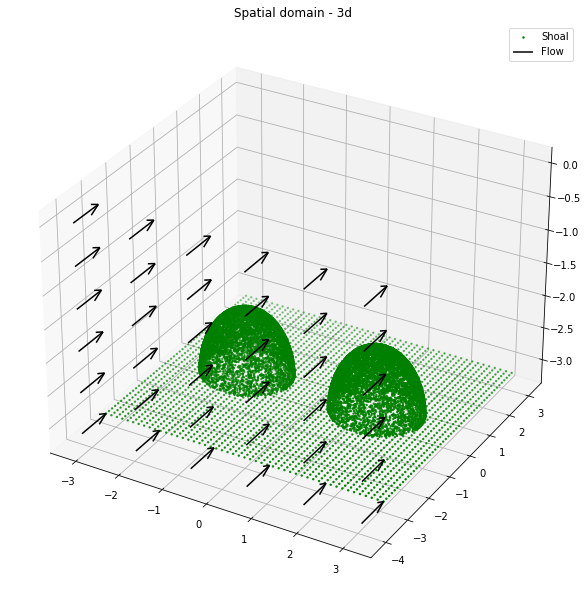

Number of points on the shoal: 17610


In [12]:
### Flow
X = jax.numpy.linspace(parameters['domain_bounds'][0,0],parameters['domain_bounds'][0,1],6)
Y = jax.numpy.linspace(parameters['domain_bounds'][1,0],parameters['domain_bounds'][1,0],1)
Z = jax.numpy.linspace(parameters['domain_bounds'][2,0],parameters['domain_bounds'][2,1],6)
X, Y, Z = jax.numpy.meshgrid(X, Y, Z)
X, Y, Z = X.flatten(), Y.flatten(), Z.flatten()
XYZ_flow = jax.numpy.column_stack((X, Y, Z))

### Plot
fig = matplotlib.pyplot.figure()
fig.set_size_inches(18.5, 10.5)
ax = fig.add_subplot(projection='3d')
title = ax.set_title('Spatial domain - 3d')
graph = ax.scatter(XYZ_shoal[:,0], XYZ_shoal[:,1], XYZ_shoal[:,2], color='green', s=2)
ax.quiver(XYZ_flow[:,0], XYZ_flow[:,1]-1, XYZ_flow[:,2], 0, 1, 0,length=1, color='black', normalize=True)
__ = ax.legend(['Shoal','Flow'])
fig.savefig('./Images/domain3d.png', facecolor='white', bbox_inches = 'tight')
matplotlib.pyplot.show()  

print('Number of points on the shoal:', XYZ_shoal.shape[0])

# Generating 2D dataset

### Boundary data

In [13]:
### Down
x = jax.numpy.linspace(parameters['domain_bounds'][0,0],parameters['domain_bounds'][0,1],parameters['n_bound']//4)
y = jax.numpy.linspace(parameters['domain_bounds'][1,0],parameters['domain_bounds'][1,0],1)
x, y = jax.numpy.meshgrid(x,y)
x, y = x.flatten(), y.flatten()
xy_front = jax.numpy.column_stack((x, y))


### Up
x = jax.numpy.linspace(parameters['domain_bounds'][0,0],parameters['domain_bounds'][0,1],parameters['n_bound']//4)
y = jax.numpy.linspace(parameters['domain_bounds'][1,1],parameters['domain_bounds'][1,1],1)
x, y = jax.numpy.meshgrid(x, y)
x, y = x.flatten(), y.flatten()
xy_behind = jax.numpy.column_stack((x, y))


### Left
x = jax.numpy.linspace(parameters['domain_bounds'][0,0],parameters['domain_bounds'][0,0],1)
y = jax.numpy.linspace(parameters['domain_bounds'][1,0],parameters['domain_bounds'][1,1],parameters['n_bound']//4)
x, y = jax.numpy.meshgrid(x,y)
x, y = x.flatten(), y.flatten()
xy_left = jax.numpy.column_stack((x, y))


### Right
x = jax.numpy.linspace(parameters['domain_bounds'][0,1],parameters['domain_bounds'][0,1],1)
y = jax.numpy.linspace(parameters['domain_bounds'][1,0],parameters['domain_bounds'][1,1],parameters['n_bound']//4)
x, y = jax.numpy.meshgrid(x, y)
x, y = x.flatten(), y.flatten()
xy_right = jax.numpy.column_stack((x, y))

xy_bound = jax.numpy.concatenate((xy_left, xy_right))

### Inside data

In [14]:
### Inside 
x = jax.numpy.linspace(parameters['domain_bounds'][0,0], parameters['domain_bounds'][0,1], int(numpy.sqrt(parameters['n_inside'])+1), endpoint=False)[1:]
y = jax.numpy.linspace(parameters['domain_bounds'][1,0], parameters['domain_bounds'][1,1], int(numpy.sqrt(parameters['n_inside'])+1), endpoint=False)[1:]
x, y = jax.numpy.meshgrid(x, y)
x, y = x.flatten(), y.flatten()
xy_inside = jax.numpy.column_stack((x, y))

### 2D plot

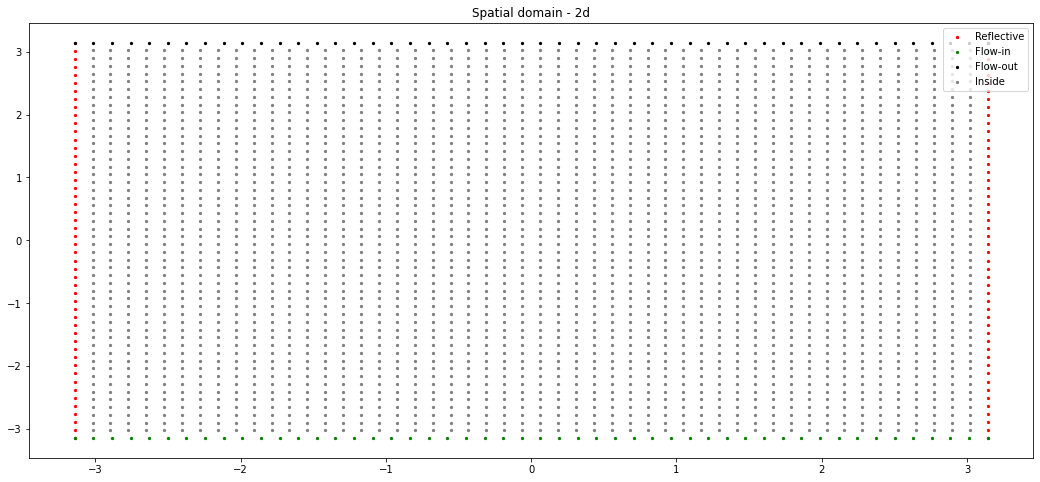

Number of points on the boundary: 200
Number of points inside the domain: 2500


In [15]:
fig, ax = matplotlib.pyplot.subplots()
fig.set_size_inches(18, 8.0)
title = ax.set_title('Spatial domain - 2d')
graph = matplotlib.pyplot.scatter(xy_bound[:,0], xy_bound[:,1], color='red', s=5)
graph = matplotlib.pyplot.scatter(xy_front[:,0], xy_front[:,1], color='green', s=5)
graph = matplotlib.pyplot.scatter(xy_behind[:,0], xy_behind[:,1], color='black', s=5)
graph = matplotlib.pyplot.scatter(xy_inside[:,0], xy_inside[:,1], color='gray', s=5)
__ = ax.legend(['Reflective', 'Flow-in','Flow-out', 'Inside'])
matplotlib.pyplot.savefig('./Images/domain2d.png', facecolor='white', bbox_inches = 'tight')
matplotlib.pyplot.show()  

print('Number of points on the boundary:', xy_bound.shape[0] + xy_front.shape[0] + xy_behind.shape[0])
print('Number of points inside the domain:', xy_inside.shape[0])

# Model initialization

In [16]:
key = jax.random.PRNGKey(parameters['seed'])
NN_MLP = MLP(key, parameters['layers'])                 
params = NN_MLP.MLP_create()              # Create the MLP
NN_eval = NN_MLP.NN_evaluation            # Evaluation function
solver = PINN(NN_eval, parameters['optimizer'], XYZ_shoal)
opt_state = parameters['optimizer'].init(params)

# Training

In [16]:
loss_history = []
print("Training start")
if parameters['options'] == 1:            # begin a new training
    loss_history = []
    loss_residual = []               # residual loss
    loss_boundary = []               # boundary loss
    loss_initial_cond = []           # boundary initial condition

    # Main loop to solve the PDE
    for ibatch in range(parameters['maximum_num_epochs']+1):
        loss, params, opt_state, losses = solver.train_step(params, opt_state, xy_inside, xy_behind, xy_front, xy_left, xy_right)

        loss_residual.append(float(losses[0]))
        loss_boundary.append(float(losses[1]))
        loss_initial_cond.append(float(losses[2]))

        losssum = jax.numpy.sum(losses)
        loss_history.append(float(losssum))

        if ibatch%parameters['report_steps']==parameters['report_steps']-1:
            print("Epoch n°{}: ".format(ibatch+1), losssum.item())

        if losssum<=numpy.min(loss_history): # save if the current state is the best 
            pickle.dump(params, open("./Checkpoints/params_checkpoint_mild", "wb"))
            pickle.dump(opt_state, open("./Checkpoints/opt_state_checkpoint_mild", "wb"))
            pickle.dump(loss_history, open("./Checkpoints/loss_history_mild", "wb"))
            pickle.dump(loss_residual, open("./Checkpoints/loss_residual_mild", "wb"))
            pickle.dump(loss_boundary, open("./Checkpoints/loss_boundary_mild", "wb"))
            pickle.dump(loss_initial_cond, open("./Checkpoints/loss_initial_cond_mild", "wb"))


elif parameters['options'] == 2:      # continue the last training
    params = pickle.load(open("./Checkpoints/params_checkpoint_mild", "rb"))
    opt_state = pickle.load(open("./Checkpoints/opt_state_checkpoint_mild", "rb"))
    loss_history = pickle.load(open("./Checkpoints/loss_history_mild", "rb"))
    loss_residual = pickle.load(open("./Checkpoints/loss_residual_mild", "rb"))
    loss_boundary = pickle.load(open("./Checkpoints/loss_boundary_mild", "rb"))
    loss_initial_cond = pickle.load(open("./Checkpoints/loss_initial_cond_mild", "rb"))
    iepoch = len(loss_history)
    
    # Main loop to solve the PDE
    for ibatch in range(iepoch,parameters['maximum_num_epochs']+1):
        loss, params, opt_state, losses = solver.train_step(params, opt_state, xy_inside, xy_behind, xy_front, xy_left, xy_right)

        loss_residual.append(float(losses[0]))
        loss_boundary.append(float(losses[1]))
        loss_initial_cond.append(float(losses[2]))

        losssum = jax.numpy.sum(losses)
        loss_history.append(float(losssum))

        if ibatch%parameters['report_steps']==parameters['report_steps']-1:
            print("Epoch n°{}: ".format(ibatch+1), losssum.item())

        if losssum<=numpy.min(loss_history): # save if the current state is the best 
            pickle.dump(params, open("./Checkpoints/params_checkpoint_mild", "wb"))
            pickle.dump(opt_state, open("./Checkpoints/opt_state_checkpoint_mild", "wb"))
            pickle.dump(loss_history, open("./Checkpoints/loss_history_mild", "wb"))
            pickle.dump(loss_residual, open("./Checkpoints/loss_residual_mild", "wb"))
            pickle.dump(loss_boundary, open("./Checkpoints/loss_boundary_mild", "wb"))
            pickle.dump(loss_initial_cond, open("./Checkpoints/loss_initial_cond_mild", "wb"))


else:
    params = pickle.load(open("./Checkpoints/params_checkpoint_mild", "rb"))
    opt_state = pickle.load(open("./Checkpoints/opt_state_checkpoint_mild", "rb"))
    loss_history = pickle.load(open("./Checkpoints/loss_history_mild", "rb"))
    loss_residual = pickle.load(open("./Checkpoints/loss_residual_mild", "rb"))
    loss_boundary = pickle.load(open("./Checkpoints/loss_boundary_mild", "rb"))
    loss_initial_cond = pickle.load(open("./Checkpoints/loss_initial_cond_mild", "rb"))

Training start
Epoch n°1000:  0.009035409655722717
Epoch n°2000:  4.1996577017420345e-05
Epoch n°3000:  0.0002290066596787435
Epoch n°4000:  0.0002498713640681026
Epoch n°5000:  5.929726666693118e-05
Epoch n°6000:  6.286118534314272e-06
Epoch n°7000:  6.041294944805511e-06
Epoch n°8000:  5.701944852993865e-06
Epoch n°9000:  5.250364715929618e-06
Epoch n°10000:  4.680185612079483e-06
Epoch n°11000:  4.008600361955716e-06
Epoch n°12000:  3.303172678677645e-06
Epoch n°13000:  2.671202855020887e-06
Epoch n°14000:  2.1730438158328862e-06
Epoch n°15000:  1.765129057184555e-06
Epoch n°16000:  1.3869980652388655e-06
Epoch n°17000:  1.0329648065038884e-06
Epoch n°18000:  7.453783099900465e-07
Epoch n°19000:  5.578690786985211e-07
Epoch n°20000:  4.3111001158574e-07
Epoch n°21000:  3.4474324040610767e-07
Epoch n°22000:  2.816155078710616e-07
Epoch n°23000:  2.5293292371893154e-07
Epoch n°24000:  2.0111472005165744e-07
Epoch n°25000:  1.7494147676136675e-07
Epoch n°26000:  1.597892251388076e-07
E

# Loss function plot

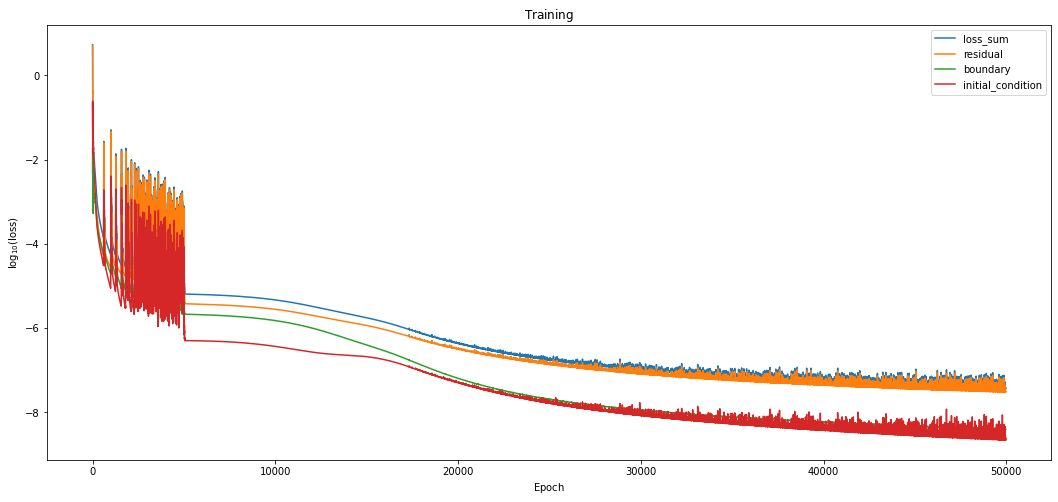

In [21]:
fig, ax = matplotlib.pyplot.subplots(1, 1)
fig.set_size_inches(18, 8.0)
__ = ax.plot(numpy.log10(loss_history))
__ = ax.plot(numpy.log10(numpy.array(loss_residual)))
__ = ax.plot(numpy.log10(numpy.array(loss_boundary)))
__ = ax.plot(numpy.log10(numpy.array(loss_initial_cond)))
xlabel = ax.set_xlabel(r'${\rm Epoch}$')
ylabel = ax.set_ylabel(r'$\log_{10}{\rm (loss)}$')
title = ax.set_title(r'${\rm Training}$')
ax.legend(['loss_sum','residual','boundary','initial_condition'])
matplotlib.pyplot.savefig('./Images/loss_function.png', facecolor='white', bbox_inches = 'tight')
matplotlib.pyplot.show()

# Elevation in t = 0

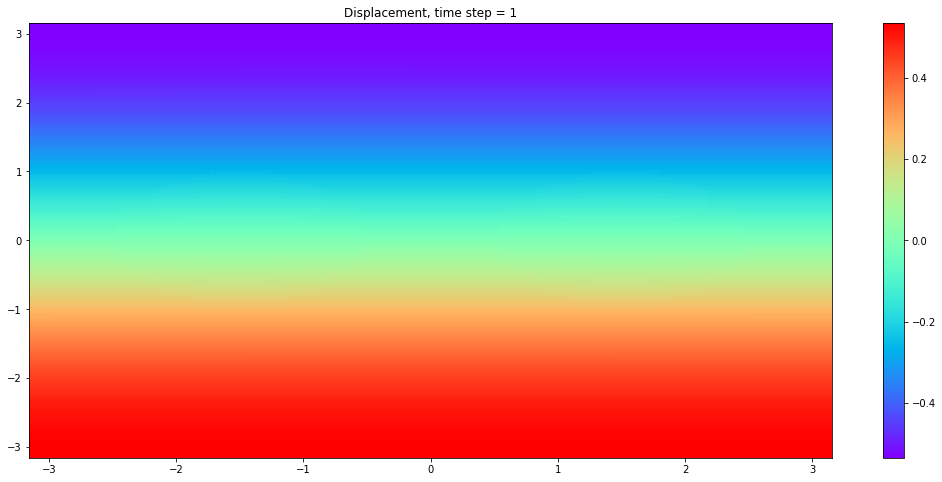

In [18]:
npoints = 200
values = numpy.zeros((npoints,npoints))
scale = 50

x = numpy.linspace(parameters['domain_bounds'][0,0], parameters['domain_bounds'][0,1], npoints)
y = numpy.linspace(parameters['domain_bounds'][1,0], parameters['domain_bounds'][1,1], npoints)
x, y = numpy.meshgrid(x, y)
t = jax.numpy.zeros(x.shape[0])

fig, ax = matplotlib.pyplot.subplots()
fig.set_size_inches(18, 8.0)
title = ax.set_title('Displacement, time step = 1')

for i in range(npoints):
    print("Plotting: {} out of {}".format(i+1, npoints), end='\r')
    values[i,:] = solver.elevation(params, x[i,:], y[i,:], t)

graph = matplotlib.pyplot.pcolormesh(x, y, scale*values, cmap = 'rainbow')
matplotlib.pyplot.colorbar()
matplotlib.pyplot.savefig('./Images/mild_slope.png', facecolor='white', bbox_inches = 'tight')
matplotlib.pyplot.show()  

# Elevation 2D animation

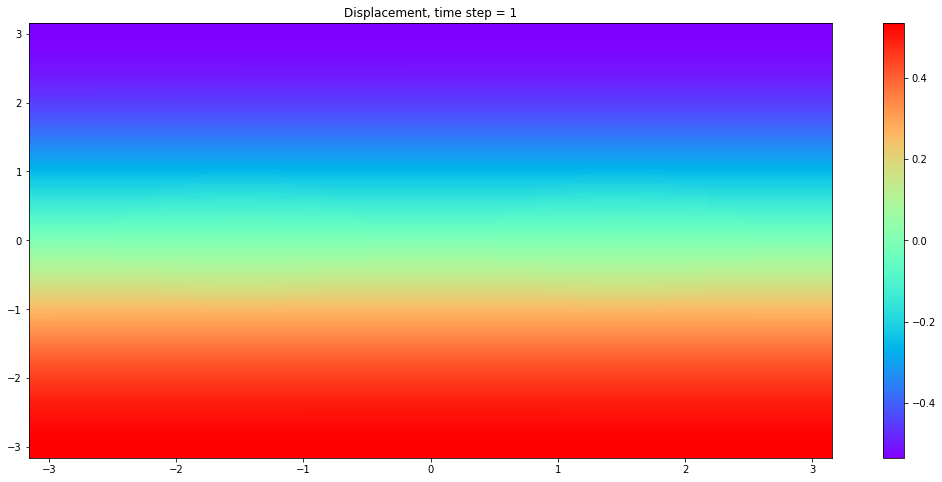

In [19]:
npoints = 200
frames = 200
end_time = 5.0
values = numpy.zeros((npoints,npoints))
scale = 50

x = numpy.linspace(parameters['domain_bounds'][0,0], parameters['domain_bounds'][0,1], npoints)
y = numpy.linspace(parameters['domain_bounds'][1,0], parameters['domain_bounds'][1,1], npoints)
x, y = numpy.meshgrid(x, y)
t = numpy.repeat(numpy.linspace(0, end_time, frames), npoints).reshape(frames, npoints)

def update_graph(num):
    print("Animating: {} out of {}".format(num+1, frames), end='\r')
    for i in range(npoints):
        values[i,:] = solver.elevation(params, x[i,:], y[i,:], t[num,:])
    title.set_text('Displacement, time step = {}'.format(num+1))
    graph.set_array(scale*values.flatten())
    return fig,

fig, ax = matplotlib.pyplot.subplots(facecolor='white')
fig.set_size_inches(18, 8.0)
title = ax.set_title('Displacement, time step = 1')

for i in range(npoints):
    values[i,:] = solver.elevation(params, x[i,:], y[i,:], t[0,:])

graph = matplotlib.pyplot.pcolormesh(x, y, scale*values, cmap = 'rainbow')
ani = matplotlib.animation.FuncAnimation(fig, update_graph, frames = frames,  blit = False)
matplotlib.pyplot.colorbar(graph, ax=ax)
matplotlib.pyplot.show()  
ani.save('./Images/mild_slope_animation2d.gif', writer='pillow', fps = 10)

# Elevation 3D animation

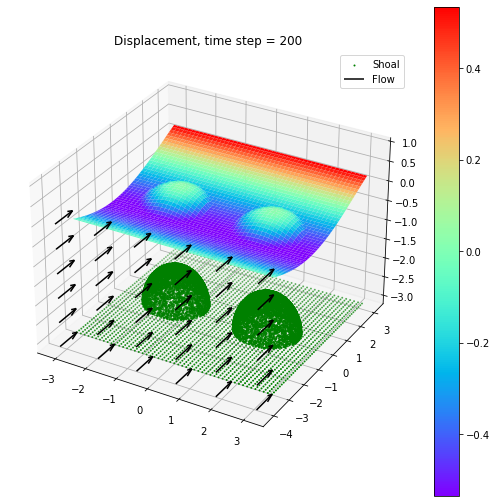

In [20]:
npoints = 200
frames = 200
end_time = 5.0
values = numpy.zeros((npoints,npoints))
scale = 50

x = numpy.linspace(parameters['domain_bounds'][0,0], parameters['domain_bounds'][0,1], npoints)
y = numpy.linspace(parameters['domain_bounds'][1,0], parameters['domain_bounds'][1,1], npoints)
x, y = numpy.meshgrid(x, y)
t = numpy.repeat(numpy.linspace(0, end_time, frames), npoints).reshape(frames, npoints)

def update_graph(num):
    print("Animating: {} out of {}".format(num+1, frames), end='\r')
    ax.cla()

    graph = ax.scatter(XYZ_shoal[:,0], XYZ_shoal[:,1], XYZ_shoal[:,2], color='green', s=1)
    ax.quiver(XYZ_flow[:,0],XYZ_flow[:,1]-1,XYZ_flow[:,2],0,1,0,length=1,color='black',normalize=True)
    for i in range(npoints):
        values[i,:] = solver.elevation(params, x[i,:], y[i,:], t[num,:])
    ax.plot_surface(x,y,scale*values,cmap='rainbow')

    __ = ax.legend(['Shoal', 'Flow'])
    ax.set_zlim(parameters['domain_bounds'][2,1], parameters['domain_bounds'][2:,0]+1)
    ax.set_title('Displacement, time step = {}'.format(num+1))

    return fig,


fig = matplotlib.pyplot.figure(facecolor='white')
fig.set_size_inches(9, 9)
ax = fig.add_subplot(111,projection='3d')

for i in range(npoints):
    values[i,:] = solver.elevation(params, x[i,:], y[i,:], t[0,:])
graph = ax.plot_surface(x, y, scale*values, cmap = 'rainbow')
matplotlib.pyplot.colorbar(graph, ax=ax)

ani = matplotlib.animation.FuncAnimation(fig, update_graph, frames = frames,  blit = False)
ani.save('./Images/mild_slope_animation3d.gif', writer='pillow', fps = 10)
